### References

## Fashion-MNIST Classification

> Can we develop a model that has good performance on the Fashion-MNIST dataset?

### Context
Fashion-MNIST is a dataset from Zalando research, comprising of <code>28 x 28</code> grayscale images of a total fo <code>70000</code> fashion products from 10 categories. The intent of this dataset is to serve as a replacement for the MNIST dataset for testing and benchmarking machine learning and deep learning models (Xiao, Rasul and Vollgraf, 2017).

The dataset is based on images from Zalando's assortment. Each original image of <code>762 x 1000</code> in JPEG format was converted to PNG, resized, and then converted to grayscale.

### Objectives
<ol>
	<li>To explore and understand the dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performance of the model</li>
	<li>Develop and experiment with models to rival state-of-the-art (SOTA) benchmark scores</li>
</ol>

## Importing libraries
We import the necessary libraries for the notebook to run below.

In [30]:
import math
from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set('notebook')
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [31]:
torch.cuda.is_available()

True

## Helper Functions
Below we define some utility and helper functions that will ease and help us with our analysis.

In [2]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list, grayscale=True):
	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	fig = plt.figure()
	# plt.tight_layout()
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			ax.imshow(arr[i * height + j], cmap='gray' if grayscale else '')
			ax.set_title(label[i * height + j])

def flip_img(arr):
	return np.flip(arr, 1)

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the original Fashion MNIST dataset found at <a href="https://arxiv.org/pdf/1708.07747v2.pdf">Paper Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 0 to 9<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 784
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
0 -> T-shirt/top
1 -> Trouser
2 -> Pullover
3 -> Dress
4 -> Coat
5 -> Sandal
6 -> Shirt
7 -> Sneaker
8 -> Bag
9 -> Ankle boot
```

In [3]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's take a look at the training dataset

In [4]:
train = pd.read_csv('data/fashion-mnist_train.csv')
train.shape

(60000, 785)

We observe that there are a total of <code>60000</code> rows and <code>785</code> columns, which is exactly what the original paper mentioned.

### Testing for missing values and invalid data
Let's try to identify if there are any missing values

In [5]:
train.isnull().sum().sum()

0

It appears <strong>no missing values are found</strong>. We will then check for any potential typos.
<ol>
	<li>Firstly, the label should only consist of values from 0 - 9</li>
	<li>Secondly, the pixel values should only fall in between and inclusive of 0 - 255</li>
</ol>

In [6]:
print('Minimum and Maximum values of labels:', train['label'].min(), "and", train['label'].max())
print("Number of values falling outside the range (0 - 255):",
	train.applymap(
		lambda x: x < 0 or x > 255 # True if out of range
	).sum().sum()
)

Minimum and Maximum values of labels: 0 and 9
Number of values falling outside the range (0 - 255): 0


We observe that the dataset seems to be properly cleaned, thus can proceed knowing that <strong>no sign of invalid or missing data have been found.</strong>

## Exploratory Data Analysis
In the EDA, we'll be attempting to complete the following set of objectives:

### EDA Objectives
<ol>
	<li>
		Is there any <strong>class imbalance</strong>
	</li>
	<li>
		What does the <strong>average image</strong> look like?
	</li>
	<li>
		Are there <strong>any outliers/anomalies</strong>?
	</li>
</ol>
Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to the following reasons:
<ul>
	<li>Time taken to train models, especially if utilising expensive layers, activation functions or architecture</li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset. We'll also stratify on the <code>label</code> to ensure that the model we generalizes best across all 
the classes.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('label', axis=1), train['label'], test_size = 10000 / len(train), stratify=train['label'])
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (50000, 784)
X_val shape: (10000, 784)
y_train shape: (50000,)
y_val shape: (10000,)


We see that the data have been split correctly and now we can begin our EDA!

### Signs of class imbalance?
We'll first identify the situation with class imbalance

<AxesSubplot: xlabel='label', ylabel='Count'>

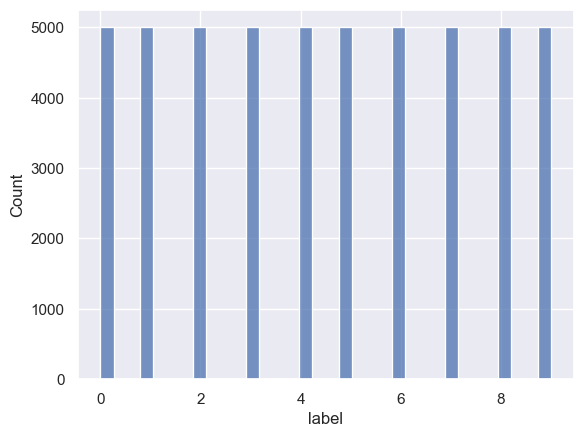

In [8]:
sns.histplot(y_train)

We observe the distribution of labels to be similar for all classes, reaching roughly a count of `5000`. Thus, there is no sign of class imbalance.

### What does the average image look like?
Let's take a look at a random sample of image each first.

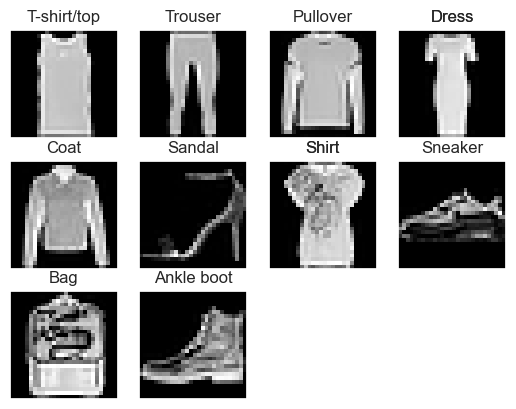

In [9]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train.loc[idx].values.reshape((28, 28)))
	titles.append(classes[y_train.loc[idx].values[0]])

imshow(images, titles)

We observe that sometimes, there appears to be certain images that are <strong>darker</strong> than others. This suggests that no form of normalization or scaling has been applied to the dataset. Let's take a look at the distribution of brightness to confirm this.

Text(0.5, 0, 'Average Brightness per Image')

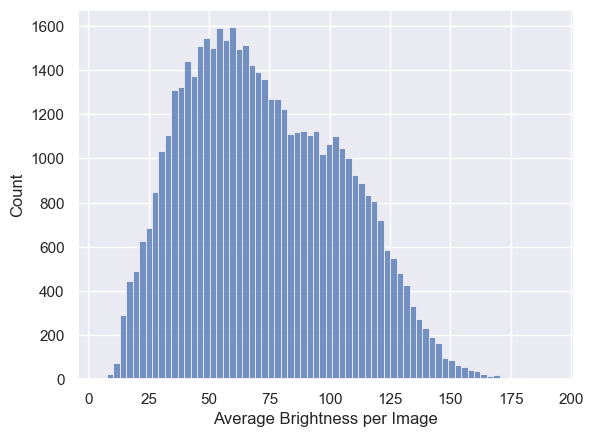

In [10]:
fig = plt.figure()
ax = fig.subplots()
sns.histplot(X_train.apply(lambda x: x.mean(), axis=1).values, ax=ax)
ax.set_xlabel('Average Brightness per Image')

We observe:
<ol>
	<li>A range of different brightness, which confirms that the data are not normalized</li>
	<li>Images tend to be on the darker side of <code>50</code> to <code>75</code> brightness</li>
	<li>The brightness of an image ranges from around <code>10</code> to around <code>162</code></li>
</ol>


To find out what the average image looks like, we'll perform an average of the pixels across the different classes.

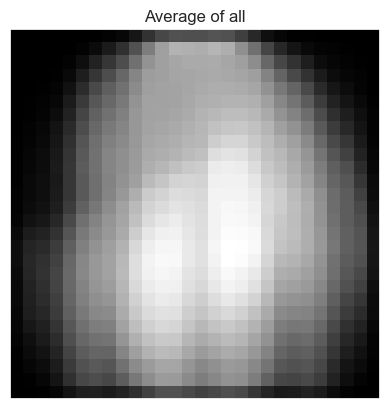

In [11]:
imshow([
	X_train.mean().apply(lambda x: int(x)).values.reshape(28, 28)
], ['Average of all'])

We observe:
<ol>
	<li>The corners of the images are dark/black. This means there is likely no piece of clothing the spreads across the image.</li>
	<li>There is a bright circle-shape in the middle. This tells us most of these images are centered around in the middle</li>
	<li>An <strong>interesting note to point out</strong> is there seems to be some sort of darker 'bar' in the middle, separating the lightest parts of the image.</li>
	<li>
		This may be due to the presence of trousers in the dataset, as from previous images, we can see trousers appears to be the only apparel with such a contrasting stripe in the middle.
	</li>
</ol>

#### Average image among the classes
Next we'll split by the classes and find the average among them.

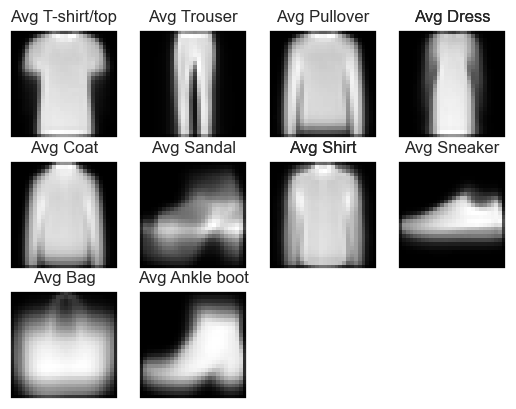

In [12]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train[y_train == i].mean().apply(lambda x: int(x)).values.reshape(28, 28))
	titles.append(f'Avg {classes[y_train.loc[idx].values[0]]}')

imshow(images, titles)

We observe:
<ol>
	<li>Each type of apparel generally has the same shape</li>
	<li>The most <strong>spread out/least consistent</strong> class seems to be sandals, as seen from the opaque and thicker edges, where as the other types have sharper and lighter borders.</li>
</ol>


### Are there any outliers/anomalies?

We see from the average images, that the piece of clothing in the image are <strong>centered and upright</strong>, in that there are no sort of rotations going on.

As such, let's see if there may be any outlier images, such as rotations or anomaly white spots on the image.

We'll start by visualizing the dataset and seeing if outliers may exist. We can do this using <code>tSNE</code>.

In [13]:
tsne = TSNE(n_jobs=-1)
data_2d = tsne.fit_transform(X_train)

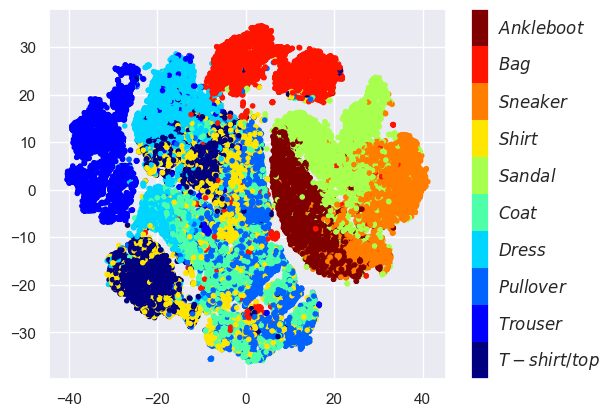

In [14]:
vis_x = data_2d[:, 0]
vis_y = data_2d[:, 1]
plt.scatter(vis_x, vis_y, c=y_train, cmap=plt.cm.get_cmap("jet", 10), marker='.')
cbar = plt.colorbar(ticks=range(10))
cbar.set_ticks([])
for j, lab in enumerate(classes):
	cbar.ax.text(1.5, j, f'${lab}$', ha='left', va='center')

cbar.ax.get_yaxis().labelpad = 15

plt.clim(-0.5, 9.5)
plt.title('Clustering Visualization with 2 components')
plt.show()

TSNE produces an <strong>incredibly interesting visualization</strong>. We observe:
<ol>
	<li>
		There is a large breakoff of clusters at the top right. Taking a look at the classes we see that they are <code>Sneaker</code>, <code>Ankleboot</code> and <code>Sandal</code>, which are all types of footwear. 
	</li>
	<li>
		Within the footwear cluster, we recognise the classes are separated distinctly, with quite sharp edges. 
	</li>
	<li>
		The large cluster in the middle contains <code>pullover</code>, <code>dress</code>, <code>t-shirt</code> and <code>shirt</code>. This cluster seems to represent the upper body clothing.
	</li>
	<li>
		In this center cluster, the classes do not have distinct edges, but <strong>rather seem to mix and mingle together</strong>. This suggests that <code>TSNE with 2 components was unable</code> to separate these classes.
	</li>
	<li>
		Lastly, the cluster at the bottom left represents <code>bag</code>. We recognise a distinct split in the center of the cluster, suggesting that there are two types of bags.
	</li>
	<li>
		Looking at the top right cluster, we recognise some red and blue data points in the wrong cluster. This may suggest <strong>presence of outliers</strong>. Let's try to identify outliers and see how we can deal with them.
	</li>
</ol>

### Using Autoencoders to identify anomalies
The idea behind this is that we can use an autoencoder to some what <strong>compress</strong> the image. We'll train this autoencoder on minimising MSE with the original image, thus the autoencoder will learn to capture the more generic and most important features. 

Thus, after an anomaly has been passed through this autoencoder, we expect the MSE to be quite high as the anomaly image does not follow the general 'style' of the images in the dataset.

In [23]:
class AnomalyAutoEncoder(nn.Module):
	def __init__(self, input_shape, **kwargs):
		super().__init__()
		self.encoder_hidden_layer = nn.Linear(
			in_features = input_shape, out_features= 128
		)

		self.encoder_output_layer = nn.Linear(
			in_features = 128, out_features = 128
		)

		self.decoder_hidden_layer = nn.Linear(
			in_features = 128, out_features = 128
		)

		self.decoder_output_layer = nn.Linear(
			in_features=128, out_features = input_shape
		)

	def forward(self, features):
		activation = self.encoder_hidden_layer(features)
		activation = torch.relu(activation)
		code = self.encoder_output_layer(activation)
		code = torch.relu(code)
		activation = self.decoder_hidden_layer(code)
		activation = torch.relu(activation)
		activation = self.decoder_output_layer(activation)
		reconstructed = torch.relu(activation)
		return reconstructed

In [24]:
device = torch.device('cuda')
model = AnomalyAutoEncoder(input_shape=784).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
15635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
40718,0,0,0,0,0,0,0,0,0,2,...,89,100,104,114,132,156,87,0,0,0
42572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
21890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
31769,0,0,0,0,0,0,0,0,0,2,...,5,0,13,156,133,123,58,0,0,9


In [26]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)

In [28]:
for batch_features, _ in train_loader:
	print(batch_features)
	break

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\p2100072\.conda\envs\pytorch\lib\site-packages\pandas\core\indexes\base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 19196

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\p2100072\.conda\envs\pytorch\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\p2100072\.conda\envs\pytorch\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\p2100072\.conda\envs\pytorch\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\p2100072\.conda\envs\pytorch\lib\site-packages\pandas\core\frame.py", line 3804, in __getitem__
    indexer = self.columns.get_loc(key)
  File "c:\Users\p2100072\.conda\envs\pytorch\lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    raise KeyError(key) from err
KeyError: 19196


In [ ]:
epochs = 50
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

## Feature Engineering

## Data Augmentation

## Modelling

## Model Improvement